In [2]:
import torch
import torch.nn as nn
from torchvision import utils, transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from PIL import Image
import os
from math import floor

In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

model_architectures = {
    # https://arxiv.org/pdf/1506.02640.pdf
    "yolov1": [
        # (kernel_width, kernel_height filters, stride)
        (7, 64, 2, 3),
        # maxpooling
        "M",
        (3, 192, 1, 1),
        "M",
        (1, 128, 1, 0),
        (3, 256, 1, 1),
        (1, 256, 1, 0),
        (3, 512, 1, 1),
        "M",
        # repeats
        [(1, 256, 1, 0), (3, 512, 1, 1), 4],
        (1, 512, 1, 0),
        (3, 1024, 1, 1),
        "M",
        [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
        (3, 1024, 1, 1),
        (3, 1024, 2, 1),
        (3, 1024, 1, 1),
        (3, 1024, 1, 1),
    ]
}

class CNNBlock(nn.Module):
    def __init__(self, in_channals, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channals, out_channels=out_channels, bias=False, **kwargs)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.batch_norm(self.conv(x)))

class YoloV1(nn.Module):
    def __init__(self, model_configuration, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self._create_conv_layers(model_configuration)
        self.fc_layers = self._create_fc_layers(**kwargs)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(torch.flatten(x, start_dim=1))
        return x

    def  _create_conv_from_layer(self, layer):
        kernel_size, filters, stride, padding = layer
        return CNNBlock(
            self.in_channels,
            filters,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        ), filters

    def _create_conv_layers(self, model_configuration):
        layers = []
        for layer in model_configuration:
            if isinstance(layer, tuple):
                conv_layer, out_channels = self._create_conv_from_layer(layer)
                layers.append(conv_layer)
                self.in_channels = out_channels

            elif isinstance(layer, str):
                if layer == "M":
                    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                elif layer == "U":
                    layers.append(nn.Upsample(scale_factor=2))

            elif isinstance(layer, list):
                repeats = layer[2]
                for _ in range(repeats):
                    for conv_layer in layer[:2]:
                        conv_layer, out_channels = self._create_conv_from_layer(conv_layer)
                        layers.append(conv_layer)
                        self.in_channels = out_channels

        return nn.Sequential(*layers)

    def _create_fc_layers(self, split_size=7, num_classes=20, num_boxes=2):
        print(f"{self.in_channels}")
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.in_channels * split_size * split_size, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, split_size**2 * (5 * num_boxes + num_classes)),
        )

### View dataset

In [10]:
import os
def get_data(csv_file, image_dir, label_dir, index):
    df = pd.read_csv(csv_file)

    row_length = len(df)
    print(row_length)

    if row_length != 0:
        from random import randint
        index = randint(0, row_length - 1)
    else:
        index = 0

    image_path = os.path.join(image_dir, df.iloc[index, 0])
    label_path = os.path.join(label_dir, df.iloc[index, 1])

    return Image.open(image_path), open(label_path).read()

1
bicycle
x=102.0, y=200.0, w=281.0, h=274.0
person
x=117.99999999999999, y=19.0, w=210.0, h=415.0


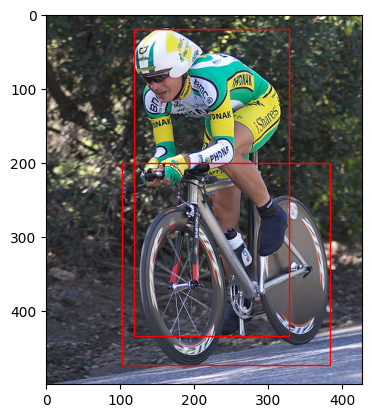

In [13]:
transform = Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

image_original, label = get_data(
    csv_file='manual_test.csv', 
    image_dir='./data/data/images',
    label_dir='./data/data/labels',
    index=0
)

bboxes = label.splitlines()
bboxes_length = len(bboxes)

fig, ax = plt.subplots(1)
ax.imshow(image_original)

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

for label in bboxes:
    class_index, x, y, w, h = label.split()
    print(classes[int(class_index)])

    # applying patch
    width, height = image_original.size
    w, h = float(w) * width, float(h) * height
    #x, y = float(x) * width - w/2, float(y) * height - h/2
    x, y = float(x) * width, float(y) * height

    print(f"{x=}, {y=}, {w=}, {h=}")

    rect = patches.Rectangle(
        (x, y),
        w,
        h,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )

    ax.add_patch(rect)

plt.show()


cuda
1024
torch.Size([3, 448, 448])

==== prediction ====

person
x=108.94111950056893, y=15.748823327677574, w=207.56419672284807, h=431.5830639430455
bicycle
x=116.02511910029821, y=204.16857940810064, w=245.95250974382674, h=276.0085548673357


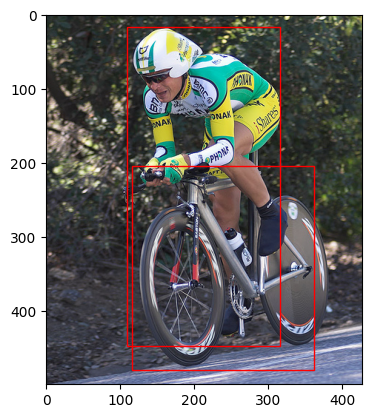

In [14]:
# auto reload
import importlib
importlib.reload(utils)

def get_bboxes(
    out, 
    split_size=7,
    num_classes=20,
    num_boxes=2
):
    bboxes = []
    for index, block in enumerate(out.reshape(split_size * split_size, 5 * num_boxes + num_classes)):
        _, class_prediction = torch.max(block[:20], dim=0, keepdim=True)
        #print(float(probability[0]), classes[int(index[0])])

        for i in range(1, num_boxes + 1):
            #print(block[20 + i * 5: 20 + (i + 1) * 5])
            prediction_probability, x, y, w, h = block[
                num_classes+(i-1)*5:num_classes+i*5
            ].tolist()
            bboxes.append([
                int(class_prediction[0]),
                prediction_probability,
                x,
                y,
                w,
                h,
                index
            ])
    return bboxes


from utils import non_max_suppression
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

if device == "cuda":
    model = YoloV1(model_architectures["yolov1"]).to(device)

    state_dict = torch.load("./trained_models/yolov1.pt")
    model.load_state_dict(state_dict["model_state_dict"])
    image = transform(image_original).to(device)
    print(image.shape)

    out = model(image.unsqueeze(0)).squeeze(0)
    bboxes = get_bboxes(out)
    bboxes = non_max_suppression(bboxes, iou_threshold=0.5, threshold=0.5)

    print("\n==== prediction ====\n")
    fig, ax = plt.subplots(1)
    ax.imshow(image_original)
    
    for label in bboxes:
        class_index, _, x, y, w, h, box_index = label
        print(classes[int(class_index)])
        
        x, y, w, h = float(x) / 7, float(y) / 7, float(w) / 7, float(h) / 7
        # applying patch
        img_width, img_height = image_original.size

        x, y = (x + box_index%7/7 - w/2) * img_width, (y + box_index//7/7 - h/2) * img_height 
        w, h = w * img_width, h * img_height

        print(f"{x=}, {y=}, {w=}, {h=}")

        rect = patches.Rectangle(
            (x, y),
            w,
            h,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        ax.add_patch(rect)

    plt.show()
